## egg2oq

Assume we have a stereo audio file, where the acoustic waveform is in the left channel, and an electroglottograph (EGG) signal is in the right channel (Herbst, 2020).

This notebook illustrates some processing steps to calculate the vocal fold vibration open quotient (OQ) from the EGG signal.


Christian T. Herbst (2020) "Electroglottography − An Update." *Journal of Voice*, **34**(4), pp. 503-526.

In [ ]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import librosa
from IPython.display import Audio

### make_frames()

Declaring here a small function that takes a waveform and returns a 2D array of frames of data

For example, a six sample waveform split into frames of three samples each, with a step/hop of 
one sample between each frame gives this:

    [1,2,3,4,5,6] --> [[1,2,3],
                         [2,3,4],
                         [3,4,5],
                         [4,5,6]]
                         
In this example the first frame is [1,2,3].

In [36]:
def make_frames(array, winsize,stride):
    '''
    make_frames(array,winsize,stride)

    takes a 1D array (one channel of audio data for example), and returns a 2D
    array of frames. each frame is 'winsize' long, and the starting points of
    the frames are at intervals of 'stride'.  'winsize' and 'stride' must be given 
    in number of samples.  Here is an example call (where fs is the sampling rate):

    frames = make_frames(signal,int(0.015*fs),int(0.005*fs))  # 15ms windows, 5ms hop

    '''
    if array.ndim > 1:
        print('make_frames() wants a 1D array')
        return None

    max_time = array.size-(winsize+1)
    
    sub_windows = (
        np.expand_dims(np.arange(winsize), 0) +
        np.expand_dims(np.arange(max_time + 1, step=stride), 0).T
    )
    return array[sub_windows]

## 1. Get Data

We have an random EGG file for illustration.

Librosa.load is used to open and downsample the stereo file.
The channels are separated into separate arrays.

In [37]:
target_fs = 16000
data, fs = librosa.load("lob_san_20230323_acg_EGG_SIGNAL_1.wav", sr=target_fs, mono=False,)
print(f'sampling rate: {fs}, Number of samples {data.shape[1]}, and channels: {data.shape[0]}')

audio = data[0]
egg_x = data[1]


sampling rate: 16000, Number of samples 15352459, and channels: 2


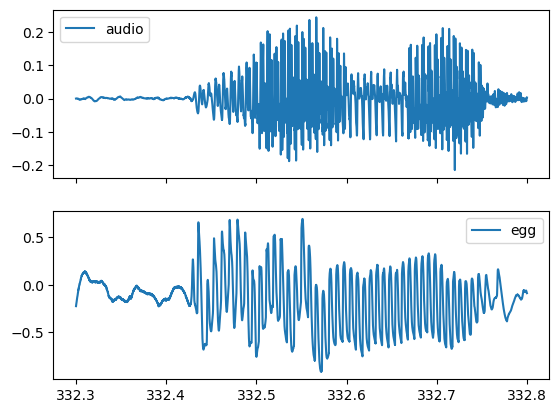

In [73]:
# plot a sample of the waveforms
time = [i/fs for i in range(audio.size)]   ## the time values associated with the waveforms, for plotting.

start = int(332.3*fs)
end = int(332.8*fs)

fig = plt.figure()
ax1 =fig.add_subplot(211,)
ax1.plot(time[start:end],audio[start:end],label="audio")
ax1.set_xticklabels([])
ax1.legend()
ax2 =fig.add_subplot(212)
ax2.plot(time[start:end],egg_x[start:end],label="egg")
ax2.legend()

## 2. Highpass filter the EGG signal

This script uses a pretty high frequency cutoff, and a pretty steep filter.
The forward/backward filtering provided by the scipy.signal.\*filtfilt does not impact the phase and thus preserves the EGG waveshape.  See Rothenburg (2002) on this filtering choice.

Rothenberg, Martin (2002) Correcting low-frequency phase distortion in electroglottograph waveforms. *Journal of Voice*, **16**(1), 32-36.

In [75]:
# highpass filter the egg signal
cutoff_freq = 70
filter_order = 8
coefs = sp.signal.butter(filter_order, cutoff_freq, fs=fs, btype='highpass', output='sos')
egg = sp.signal.sosfiltfilt(coefs, egg_x)

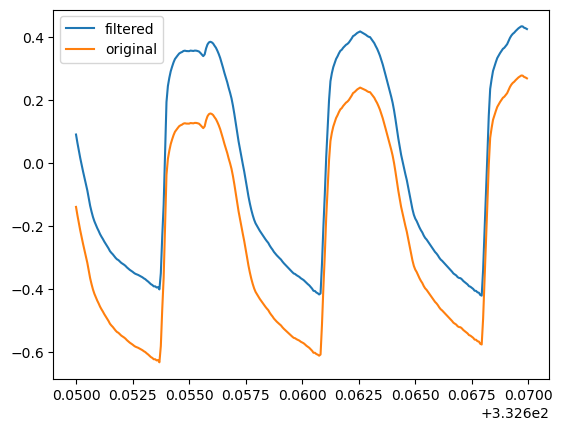

In [76]:
# the filtering must preserve the waveform shape

start = int(332.65*fs)
end = int(332.67*fs)

plt.plot(time[start:end],egg[start:end],label="filtered")
plt.plot(time[start:end],egg_x[start:end],label="original")
plt.legend()

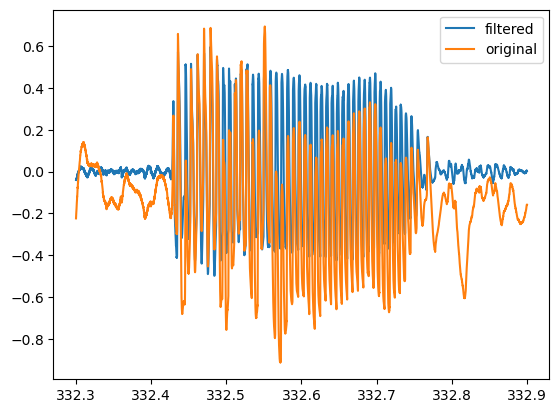

In [77]:
# and remove large/slow fluctuations

start = int(332.3*fs)
end = int(332.9*fs)

plt.plot(time[start:end],egg[start:end],label="filtered")
plt.plot(time[start:end],egg_x[start:end],label="original")

plt.legend()

## 3. Find glottal closing and opening events

Using normalized EGG and dEGG signals, we here find glottal closing and opening events using the 'hybrid' method, that is reviewed in Herbst(2020).

scipy.signal.find_peaks() is applied to the degg signal, to find glottal closure instances (GCI), and a threshold of 0.43 in the normalized EGG is used to find glottal opening instances (GOI).

An additional signal using the 'thresholding' method is created but not used.

In [65]:
degg = np.gradient(egg)

# scale the filtered egg and degg to (0,1)
egg = (egg - np.min(egg))/(np.max(egg)-np.min(egg))
degg = (degg - np.min(degg))/(np.max(degg)-np.min(degg))

# ** thresholding method of calculating closed quotient could use this signal (not used)
closed = egg > 0.43  

# ** hybrid method of OQ calculation
# get peaks in the degg waveform - the glottal closing instants (gci)
# minimum spacing between peaks (distance) is 5.5 ms
degg_peaks = sp.signal.find_peaks(degg,distance=0.0055*fs) 
glottal = np.zeros(degg.size)
glottal[degg_peaks[0]]=1  # closing times (peaks returns indices of peaks)
for i in range(egg.size-1):  # opening times (threshold method)
    if egg[i]>0.43 and egg[i+1]<0.43:
        glottal[i] = -1


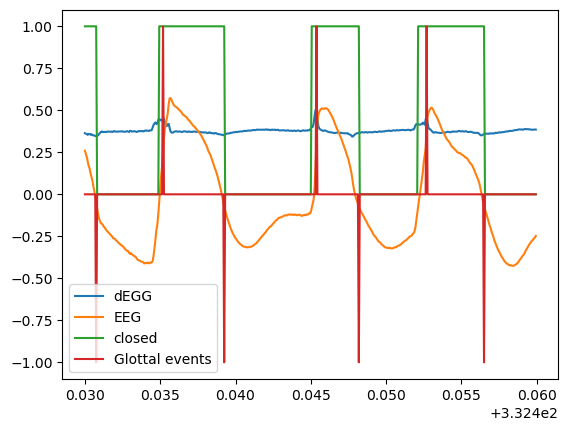

In [81]:
start = int(332.43*fs)
end = int(332.46*fs)

plt.plot(time[start:end],degg[start:end],label="dEGG")
plt.plot(time[start:end],egg[start:end],label="EEG")
plt.plot(time[start:end],closed[start:end],label="closed")
plt.plot(time[start:end],glottal[start:end],label="Glottal events")
plt.legend()


## 4. Calculate OQ from the glottal events waveform

- The glottal events waveform is split into frames, and find indices of GCI and GOI in each frame.

- If there are no glottal events we will leave 0 as the measure of OQ (and F0).

- Take the duration of the first pitch period in the frame.  Find a GOI that occurs in the first pitch period in the frame.

- Save the open quotient and F0 for the frame, derived from these measures.

In [82]:
window_length = 0.02
hop_dur = 0.005
frame_rate = 1/hop_dur

win = int(window_length*fs)  # 15ms windows, 
hop = int(hop_dur*fs)  # 5ms hop


frames = make_frames(glottal,win,hop)   # split the glottal events waveform into frames
ftime = [i/frame_rate for i in range(frames.shape[0])]  # get times of frames, for plotting

print(f'{frames.shape[0]} frames will be processed')

f0 = np.zeros(frames.shape[0])
OQ = np.zeros(frames.shape[0])
    
for k in range(frames.shape[0]):
    
    gci = np.argwhere(frames[k] == 1.0)  # glottal closures in the frame
    goi = np.argwhere(frames[k] == -1.0)  # glottal openings
    if (gci.size<2):  # nothing to look at
        continue
    if (goi.size<2):  # nothing to look at
        continue

    period = gci[1]-gci[0]  # interval between closures
    f0[k] = 1/(period/fs)
    if goi[0] > gci[0] and goi[0]<gci[1]:  # find an appropriate opening instant
        op = goi[0]
    elif goi[1] > gci[0] and goi[1]<gci[1]: 
        op = goi[1]
    else:
        continue
        
    OQ[k] = (gci[1]-op)/period

191902 frames will be processed


In [ ]:
## Explore

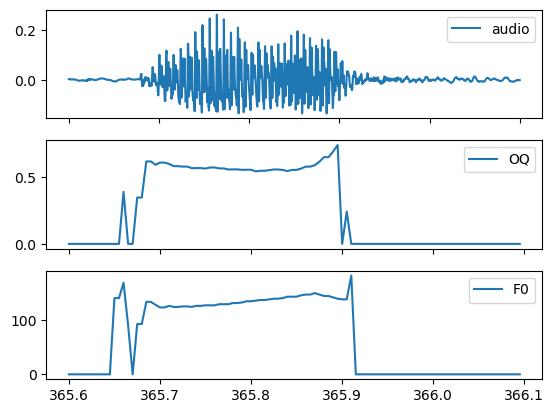

In [86]:
start_time = 365.6
end_time = start_time + 0.5

start_sample = int(start_time*fs)
end_sample = int(end_time*fs)

start_frame = int(start_time*frame_rate)
end_frame = int(end_time*frame_rate)


fig = plt.figure()
ax1 =fig.add_subplot(311,)
ax1.plot(time[start_sample:end_sample],audio[start_sample:end_sample],label="audio")
ax1.set_xticklabels([])
ax1.legend()
ax2 =fig.add_subplot(312)
ax2.plot(ftime[start_frame:end_frame],OQ[start_frame:end_frame],label="OQ")
ax2.set_xticklabels([])
ax2.legend()
ax3 =fig.add_subplot(313)
ax3.plot(ftime[start_frame:end_frame],f0[start_frame:end_frame],label="F0")
ax3.legend()

Audio(audio[start_sample:end_sample],rate=fs)